# Predicting the Daily Ridership

From the service operation perspective, it would be very useful if ridership on a given day can be predicted. Here, I attempted to predict the future ridership in the future using a model trained on the past data. Random Forest Regressor was chosen based in preliminary analysis. Here, a predictive model was assessed in two ways as shown below.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

In [2]:
# Scoring function for a regressor
def score_regressor(regressor, X, y, X_train=None, y_train=None):
    
    result = {}
    
    y_pred = regressor.predict(X)
    
    # calculate R^2 and MSE
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    scores = {'r2_score': r2,
                     'mse': mse}
    
    result['scores'] = scores
    
    # If train option is on, return results for the training set too
    if (X_train is not None) & (y_train is not None):
        
        y_pred_train = regressor.predict(X_train)
        
        r2_train = r2_score(y_train, y_pred_train)
        mse_train = mean_squared_error(y_train, y_pred_train)

        scores_train = {'r2_score': r2_train,
                                    'mse': mse_train}
        
        result['scores_train'] = scores_train
    
    # If the regressor has feature importances attribute, include in the result
    try:
        result['feature_importances'] = regressor.feature_importances_
    except:
        pass
    
    return result

# A method to print out the regression scores
def print_regressor_scores(result, trainset=False, feature_labels=None):
    
    print('==== Regressor Performance ====')
    if trainset:
        print('Train: R2 = %f, mse = %f'  % (result['scores_train']['r2_score'], result['scores_train']['mse']))
    print('Test: R2 = %f, mse = %f'  % (result['scores']['r2_score'], result['scores']['mse']))
    
    if (feature_labels is not None):
        importances = result['feature_importances']
        indices = np.argsort(importances)[::-1]
        print('--------------- Feature Importances ---------------')
        for f in range(len(feature_labels)):
            print('%2d) %-*s %f' % (f + 1, 20, feature_labels[indices[f]], importances[indices[f]]))
        print('\n')
        
    return

# Importing the subscriber data

In [3]:
# Import subscriber data and remove entries with NaN
data = pd.read_csv('../data/for_predictions/daily_p_s_pred_basic.csv')
data = data.dropna()

In [4]:
# Remove entries that have negative wind strength
data = data[data['AWND'] >= 0]

In [5]:
# Create date field and convert it to datetime object
data['date'] = data['year'].astype(str) + '-' + data['month'].astype(str) + '-' + data['day'].astype(str) 
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

In [6]:
# Check the columns
data.columns

Index(['year', 'month', 'day', 'dayofweek', 'st_latitude', 'st_longitude',
       'closest_college_distance', 'closest_subway_distance',
       'closest_theater_distance', 'closest_museum_distance',
       'closest_park_distance', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND',
       'pickups', 'date'],
      dtype='object')

In [7]:
# Reorder the columns and  preview the data
data = data[['date', 'year', 'month', 'day', 'dayofweek', 'st_latitude', 'st_longitude',
       'closest_college_distance', 'closest_subway_distance',
       'closest_theater_distance', 'closest_museum_distance',
       'closest_park_distance', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND',
       'pickups']]
data.head()

,date,year,month,day,dayofweek,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,pickups
0,2013-07-01,2013,7,1,0,40.767272,-73.993929,0.449863,0.836766,0.509623,0.648424,0.190527,21.3,0.0,0.0,25.0,22.2,1.4,47
1,2013-07-01,2013,7,1,0,40.719116,-74.006667,0.438224,0.012754,0.179887,0.470931,0.154135,21.3,0.0,0.0,25.0,22.2,1.4,73
2,2013-07-01,2013,7,1,0,40.711174,-74.000165,0.390559,0.372382,0.416180,0.590027,0.143915,21.3,0.0,0.0,25.0,22.2,1.4,13
3,2013-07-01,2013,7,1,0,40.683826,-73.976323,0.970719,0.176488,3.503029,0.224781,0.108015,21.3,0.0,0.0,25.0,22.2,1.4,19
4,2013-07-01,2013,7,1,0,40.741776,-74.001497,0.717327,0.062889,0.234855,0.368229,0.170808,21.3,0.0,0.0,25.0,22.2,1.4,47


In [8]:
# Check basic stats of the data
data.describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).round(3)

,year,month,day,dayofweek,st_latitude,st_longitude,closest_college_distance,closest_subway_distance,closest_theater_distance,closest_museum_distance,closest_park_distance,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,pickups
count,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000,540042.000
mean,2015.075,6.681,15.700,2.982,40.727,-73.983,0.672,0.284,1.211,0.694,0.151,2.983,2.013,14.315,17.109,9.128,2.402,63.516
std,1.166,3.599,8.832,2.000,0.028,0.018,0.431,0.238,1.343,0.658,0.027,8.225,15.293,57.784,10.284,9.538,1.048,62.068
min,2013.000,1.000,1.000,0.000,40.518,-74.031,0.022,0.003,0.011,0.019,0.088,0.000,0.000,0.000,-9.300,-18.200,0.300,1.000
25%,2014.000,3.000,8.000,1.000,40.705,-73.996,0.338,0.100,0.278,0.280,0.129,0.000,0.000,0.000,8.300,2.200,1.700,18.000
50%,2015.000,7.000,16.000,3.000,40.725,-73.984,0.604,0.224,0.556,0.505,0.153,0.000,0.000,0.000,17.800,8.900,2.200,44.000
75%,2016.000,10.000,23.000,5.000,40.749,-73.971,0.911,0.414,2.008,0.797,0.171,1.000,0.000,0.000,26.700,17.800,3.000,90.000
95%,2017.000,12.000,30.000,6.000,40.773,-73.948,1.447,0.774,4.081,2.275,0.189,18.300,0.000,130.000,31.700,22.800,4.400,184.000
99%,2017.000,12.000,31.000,6.000,40.790,-73.940,1.895,1.006,5.125,3.199,0.204,40.100,76.000,300.000,34.400,25.600,5.500,277.000
max,2017.000,12.000,31.000,6.000,40.804,-73.930,11.939,7.748,21.617,7.715,0.218,126.200,279.000,480.000,36.700,28.300,8.200,827.000


# Predicting future usage by walk-forward testing
- Decide on a cutoff date at which to split the dataset into train/test sets 
- Fit model with train set, test its perfromance on test set
- Shift cutoff date by certain interval, repeat the train/test cycle
- Assess how performance change over time and identify optimal cutoff date

<b>Predicting the whole remaining window in the future part</b>
- Test set is all the remaining data after the cutoff date

In [9]:
%%time
# Set up initial split date, end date for iteration, and shift interval
split_date = dt.date(2013, 10, 30)
end_date = dt.date(2016, 12, 31)
shift = dt.timedelta(days=15)

# Set up data containers
split_dates = []
train_r2s = []
test_r2s = []
train_mses = []
test_mses = []
counter = []

i = 0     # Set up a counter
while split_date <= end_date:
    
    # Split the data
    past = data[data['date'] <= split_date]
    future = data[data['date'] > split_date]
    
    # Set up Xs and ys
    X_past = past[past.columns[1:-1]]
    X_future = future[future.columns[1:-1]]
    y_past = past[past.columns[-1]]
    y_future = future[future.columns[-1]]

    X_past = np.array(X_past).reshape(X_past.shape)
    X_future = np.array(X_future).reshape(X_future.shape)
    y_past = np.array(y_past).reshape(-1, 1).ravel()
    y_future = np.array(y_future).reshape(-1, 1).ravel()
    
    # Train RandomForestRegressor
    regressor = RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=4)
    regressor.fit(X_past, y_past)
    
    # Score with the test set (future set)
    result = score_regressor(regressor, X_future, y_future, X_train=X_past, y_train=y_past)
    
    train_r2s.append(result['scores_train']['r2_score'])
    train_mses.append(result['scores_train']['mse'])
    test_r2s.append(result['scores']['r2_score'])
    test_mses.append(result['scores']['mse'])
    
    # print progress
    if (i % 10) == 0:
        print('Split at', split_date, ': R^2 on test = %f' % result['scores']['r2_score'])
    
    # Store split date and the counter
    split_dates.append(split_date)
    counter.append(i)
    
    # update the split date and the counter
    i += 1
    split_date += shift

print('...Process Complete.')

Split at 2013-10-30 : R^2 on test = 0.355578
Split at 2014-03-29 : R^2 on test = 0.589325
Split at 2014-08-26 : R^2 on test = 0.642250
Split at 2015-01-23 : R^2 on test = 0.623093
Split at 2015-06-22 : R^2 on test = 0.607261
Split at 2015-11-19 : R^2 on test = 0.720652
Split at 2016-04-17 : R^2 on test = 0.783017
Split at 2016-09-14 : R^2 on test = 0.818570
...Process Complete.
CPU times: user 1h 47min 12s, sys: 1min 43s, total: 1h 48min 56s
Wall time: 28min 58s


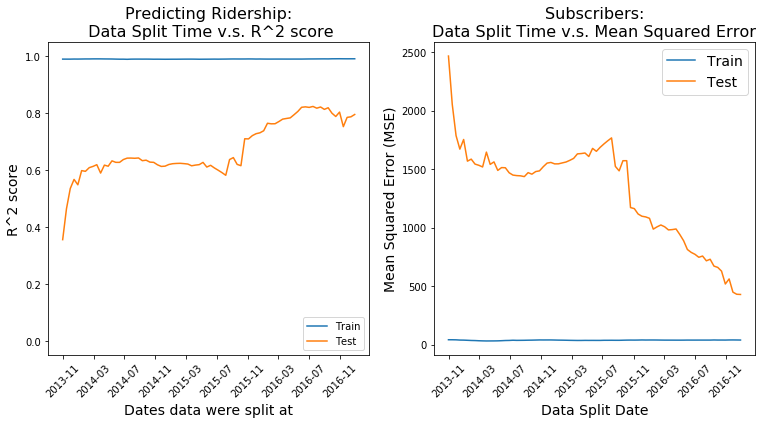

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 6), sharex=True)
ax1.plot(split_dates, train_r2s, label='Train')
ax1.plot(split_dates, test_r2s, label='Test')
ax1.set_xlabel('Dates data were split at', fontsize=14)
ax1.set_ylabel('R^2 score', fontsize=14)
ax1.set_title('Predicting Ridership:\n Data Split Time v.s. R^2 score', fontsize=16)
ax1.legend(loc='lower right')
ax1.set_ylim([-0.05, 1.05])

ax2.plot(split_dates, train_mses, label='Train')
ax2.plot(split_dates, test_mses, label='Test')
ax2.set_xlabel('Data Split Date', fontsize=14)
ax2.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
ax2.set_title('Subscribers:\nData Split Time v.s. Mean Squared Error', fontsize=16)
ax2.legend(loc='upper right', fontsize=14)

for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

plt.tight_layout()

In [16]:
# print out the best R^2 score and the split date for it
best_score = np.max(test_r2s)
best_split_date = split_dates[np.argmax(test_r2s)]
print('Best R^2 score = %f on %s' % (best_score, str(best_split_date)))

Best R^2 score = 0.823104 on 2016-07-16


<b>Predicting only the 90-day period following the cutoff date</b>
- Test set is the remaining data for the 90days following the cutoff date

In [17]:
%%time
# Set up initial split date, end date for iteration, and shift interval
# Now window is also set up as a prediction window
split_date = dt.date(2013, 10, 30)
end_date = dt.date(2016, 12, 31)
shift = dt.timedelta(days=15)
window = dt.timedelta(days=90)

# Set up results container
split_dates = []
train_r2s = []
test_r2s = []
train_mses = []
test_mses = []
counter = []

i = 0
while split_date <= end_date:
    
    # Split the data
    past = data[data['date'] <= split_date]
    future = data[(data['date'] > split_date) & (data['date'] <= (split_date + window))]
    
    # Set up Xs and ys
    X_past = past[past.columns[1:-1]]
    X_future = future[future.columns[1:-1]]
    y_past = past[past.columns[-1]]
    y_future = future[future.columns[-1]]

    X_past = np.array(X_past).reshape(X_past.shape)
    X_future = np.array(X_future).reshape(X_future.shape)
    y_past = np.array(y_past).reshape(-1, 1).ravel()
    y_future = np.array(y_future).reshape(-1, 1).ravel()
    
    # Train RandomForestRegressor
    regressor = RandomForestRegressor(max_depth=40, n_estimators=50, n_jobs=4)
    regressor.fit(X_past, y_past)
    
    # Score with the test set (future set)
    result = score_regressor(regressor, X_future, y_future, X_train=X_past, y_train=y_past)
    
    train_r2s.append(result['scores_train']['r2_score'])
    train_mses.append(result['scores_train']['mse'])
    test_r2s.append(result['scores']['r2_score'])
    test_mses.append(result['scores']['mse'])
    
    # print progress
    if (i % 10) == 0:
        print('Split at', split_date, ': R^2 on test = %f' % result['scores']['r2_score'])
    
    # Store split date and the counter
    split_dates.append(split_date)
    counter.append(i)
    
    # update the split date and the counter
    i += 1
    split_date += shift

print('...Process Complete.')

Split at 2013-10-30 : R^2 on test = -0.482733
Split at 2014-03-29 : R^2 on test = 0.619246
Split at 2014-08-26 : R^2 on test = 0.837189
Split at 2015-01-23 : R^2 on test = 0.769239
Split at 2015-06-22 : R^2 on test = 0.791690
Split at 2015-11-19 : R^2 on test = 0.577890
Split at 2016-04-17 : R^2 on test = 0.794858
Split at 2016-09-14 : R^2 on test = 0.825125
...Process Complete.
CPU times: user 1h 42min 22s, sys: 1min 32s, total: 1h 43min 54s
Wall time: 27min 32s


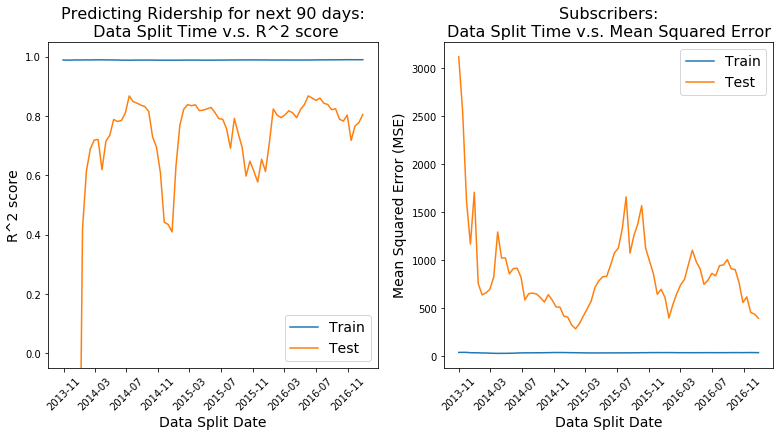

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), sharex=True)
ax1.plot(split_dates, train_r2s, label='Train')
ax1.plot(split_dates, test_r2s, label='Test')
ax1.set_xlabel('Data Split Date', fontsize=14)
ax1.set_ylabel('R^2 score', fontsize=14)
ax1.set_title('Predicting Ridership for next 90 days:\n Data Split Time v.s. R^2 score', fontsize=16)
ax1.legend(loc='lower right', fontsize=14)
ax1.set_ylim([-0.05, 1.05])

ax2.plot(split_dates, train_mses, label='Train')
ax2.plot(split_dates, test_mses, label='Test')
ax2.set_xlabel('Data Split Date', fontsize=14)
ax2.set_ylabel('Mean Squared Error (MSE)', fontsize=14)
ax2.set_title('Subscribers:\nData Split Time v.s. Mean Squared Error', fontsize=16)
ax2.legend(loc='upper right', fontsize=14)

for tick in ax1.get_xticklabels():
        tick.set_rotation(45)
for tick in ax2.get_xticklabels():
        tick.set_rotation(45)

In [19]:
# print out the best R^2 score and the split date for it
best_score = np.max(test_r2s)
best_split_date = split_dates[np.argmax(test_r2s)]
print('Best R^2 score = %f on %s' % (best_score, str(best_split_date)))

Best R^2 score = 0.868435 on 2016-06-01
